In [2]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import gensim
from gensim.test.utils import common_texts

# load config
with open('config.json', 'r') as f:
    config = json.load(f)
cwd = os.getcwd()
os.chdir(config['REPODIR'])
import Helper as H
from Corpus import Corpus
os.chdir(cwd)

from collections import Counter, defaultdict
import itertools

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
import pickle as pkl
from sklearn.decomposition import PCA
import nltk

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
with open("data_vFinal.pkl", "rb") as infile:
        data = pkl.load(infile)

In [4]:
data_df = pd.DataFrame(data)
data_df.head()

,author_id,author_name,book_id,gutenbergbookid,title_x,text,text_lines,Unnamed: 0,id,title_y,...,authoryearofbirth,authoryearofdeath,language,downloads,subjects,type,Sub_A,Sub_B,Sub_C,gbid
0,1389,"Jefferson, Thomas",31479,1,The Declaration of Independence of the United ...,[to express the vagaries of a poetical fancy t...,3381,1,PG1,The Declaration of Independence of the United ...,...,1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text,History,United States,Revolution,1
1,1389,"Jefferson, Thomas",31479,1,The Declaration of Independence of the United ...,"[characteristics: entire purity of tone, warmt...",4181,1,PG1,The Declaration of Independence of the United ...,...,1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text,History,United States,Revolution,1
2,1389,"Jefferson, Thomas",31479,1,The Declaration of Independence of the United ...,"[orange, fig, pomegranate, plum, and peach tre...",5131,1,PG1,The Declaration of Independence of the United ...,...,1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text,History,United States,Revolution,1
3,1389,"Jefferson, Thomas",31479,1,The Declaration of Independence of the United ...,"[ * * * * *, , M...",2681,1,PG1,The Declaration of Independence of the United ...,...,1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text,History,United States,Revolution,1
4,1389,"Jefferson, Thomas",31479,1,The Declaration of Independence of the United ...,"[forms the wall of the original crater, but no...",9631,1,PG1,The Declaration of Independence of the United ...,...,1743.0,1826.0,['en'],604.0,"{'United States -- History -- Revolution, 1775...",Text,History,United States,Revolution,1


In [31]:
subsample = data_df.sample(10000, random_state=0)

subject_b = [s for s in subsample['Sub_B']]
other_subject = [s if s != 'Fiction' else subject_b[idx] for idx, s in enumerate(subsample['Sub_A']) ]

subsample['sub'] = other_subject

Fetch works for every book

In [32]:
data = subsample.to_dict(orient='records')

In [33]:
data_text = [dat['text'] for dat in data]
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokenized_text = [tokenizer.tokenize(' '.join(text)) for text in data_text]
joined_text = [' '.join(text) for text in data_text]

In [34]:
# Worked fine with 'glove-wiki-gigaword-300'

import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [35]:
for idx, d in enumerate(data):
    d['vectors'] = []
    for token in tokenized_text[idx]:
        try:
            d['vectors'].append(glove_vectors[token])
        except:
            continue
    d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
    if not d['mean_vector'].shape:
        d['mean_vector'] = np.zeros((100,))
    d['key'] = str(d['book_id']) + str(d['text_lines'])
    #  d['subject'] = catalog[catalog['book_id'] == d['book_id']].iloc[0, 9]

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_1890/1942627058.py:8: RuntimeWarning:

Mean of empty slice.

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning:

invalid value encountered in scalar divide



In [36]:
# mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape and d['subject'] != 'Other'])
mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape])

In [37]:
# ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape and d['subject'] != 'Other']
ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape]

In [38]:
titles = [data[idx]['title_x'] for idx in ids]
subjects = [data[idx]['sub'] for idx in ids]
# decade = [int(data[idx]['decade']) for idx in ids]
yob = [int(data[idx]['authoryearofbirth']) for idx in ids]
# gender = [1 if data[idx]['gender'] == "F" else 0 for idx in ids]
# penname =[1 if data[idx]['penname'] == "Y" else 0 for idx in ids]
# pn_gend = [str(penname[idx]) + str(gender[idx]) for idx in ids]

In [39]:
data[9]

{'author_id': 49,
 'author_name': 'Disraeli, Benjamin, Earl of Beaconsfield',
 'book_id': 9320,
 'gutenbergbookid': 7412,
 'title_x': 'Coningsby; Or, The New Generation',
 'text': ["doctor; na, na, gie yir siller tae some puir body, Maister Hopps,' an'",
  'he was doon the road as hard as he cud lick."',
  '',
  'His fees were pretty much what the folk chose to give him, and he',
  'collected them once a year at Kildrummie fair.',
  '',
  '"Well, doctor, what am a\' awin\' ye for the wife and bairn? Ye \'ill need',
  'three notes for that nicht ye stayed in the hoose an\' a\' the veesits."',
  '',
  '"Havers," MacLure would answer, "prices are low, a\'m hearing; gie\'s',
  'thirty shillings."',
  '',
  '"No, a\'ll no, or the wife \'ill tak ma ears off," and it was settled for',
  'two pounds. Lord Kilspindie gave him a free house and fields, and one',
  'way or other, Drumsheugh told me, the doctor might get in about L150.',
  "a year, out of which he had to pay his old housekeeper's w

In [53]:
two_dim = mean_vectors


In [48]:
# two_dim = PCA(random_state =0).fit_transform(mean_vectors)[:1000,]
# two_dim = PCA(random_state =0).fit_transform(mean_vectors)


In [65]:
xPCA = two_dim[:,0]; yPCA = two_dim[:,1]
xPCA.shape

(10000,)

<Axes: >

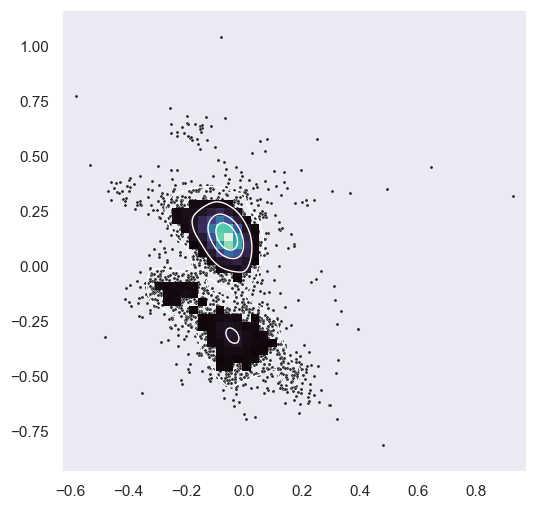

In [66]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=xPCA, y=yPCA, s =5, color=".15")
sns.histplot(x=xPCA, y=yPCA, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=xPCA, y=yPCA, levels=5, color="w", linewidths=1)

In [18]:
import plotly.express as px

def pca_scatterplot_3D(model, user_input=None, color_map=None, sentences = None):

    # three_dim = user_input[:,:3]
    three_dim = PCA(random_state=0).fit_transform(user_input)[:,:3]

    df = pd.DataFrame(three_dim)
    df['Label'] = color_map
    df['sentence'] = sentences

    plot_figure = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'Label', hover_name = 'sentence', size_max = 2)

    plot_figure.show()

In [19]:

# For use in the famous literature set
# decade_gender = [int(str(decade[idx]) + str(gender[idx])) for idx in ids]

In [68]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=5, covariance_type="full").fit(two_dim)
clusters = gmm.predict(mean_vectors)

In [69]:
# pca_scatterplot_3D(data, user_input = two_dim, color_map = [str(c) for c in clusters], sentences = titles)
pca_scatterplot_3D(data, user_input = two_dim, color_map = clusters, sentences = subjects)

In [45]:
extract_data = []

for i, idx in enumerate(ids):
    data[idx]['cluster'] = str(clusters[i])
    extract_data.append(data[idx].copy())



In [46]:
t = pd.DataFrame(extract_data).groupby(by = ['cluster', 'sub']).agg('count')

In [ ]:
ed = pd.DataFrame(extract_data)

In [ ]:
# ed[ed['cluster'] == 3].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [47]:
t['key'].unstack(0).divide(sum(t['key']))

cluster,0,1,2,3,4
sub,,,,,
"""Childrens stories""",NaN,NaN,NaN,0.000104,0.000207
1764-1807,NaN,NaN,NaN,NaN,0.000311
1789-1799,NaN,NaN,NaN,NaN,0.000104
1866,NaN,NaN,NaN,NaN,0.000104
1869-1916,NaN,NaN,NaN,NaN,0.000104
...,...,...,...,...,...
Young women -- Fiction,0.000104,NaN,NaN,NaN,NaN
Yukon River Valley (Yukon and Alaska),NaN,NaN,NaN,NaN,0.000104
Zimbabwe,NaN,0.000104,NaN,NaN,NaN
